In [596]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, scale, minmax_scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from numpy import array



In [646]:
def calculate_NMAE(predict_val, actual_val):
    
    return mean_absolute_error(predict_val, actual_val, multioutput='raw_values')/actual_val.mean()

def train_ANN_model(x_train, y_train, epoch_num, batch_size):
    # return the model you train
    
    input_dimension = x_train.shape[1]
    output_dimension = y_train.shape[1]
    middle_dimension = int((input_dimension+output_dimension)/2)
    
    opt=keras.optimizers.Adam(lr=0.1)
    ann_model = Sequential()
    ann_model.add(Dense(middle_dimension, input_dim = input_dimension, activation = 'relu'))
#     ann_model.add(Dense(middle_dimension, activation = 'relu'))
    ann_model.add(Dense(output_dimension, activation = 'linear'))
    ann_model.compile(opt,loss='mean_squared_error',metrics=['accuracy'])

    ann_model.fit(x_train, y_train, epochs = epoch_num, batch_size = batch_size)
    
    return ann_model
    
def test_ANN_model(model, x_test, y_test):
    # return the NMAE value

    y_pred_ann = model.predict(x_test)
    return y_pred_ann, calculate_NMAE(y_pred_ann, y_test)

def use_ANN_model(x_train, y_train, x_test, y_test, epoch_num, batch_size):
    
    model = train_ANN_model(x_train, y_train, epoch_num, batch_size)
    
    y_pred, NMAE_val = test_ANN_model(model, x_test, y_test)
    
    return y_pred, NMAE_val


def use_LR_model(x_train, y_train, x_test, y_test):
    Linear = LinearRegression()
    Linear.fit(x_train, y_train)
    y_pred_linear= Linear.predict(x_test)
    NMAE = calculate_NMAE(y_pred_linear, y_test)
    return y_pred_linear, NMAE

def use_RF_model(x_train, y_train, x_test, y_test):
    forest = RandomForestRegressor()
    forest.fit(x_train, y_train)
    y_pred_forest= forest.predict(x_test)
    NMAE = calculate_NMAE(y_pred_forest, y_test)
    return y_pred_forest, NMAE
    
# input data should be np array, only outliers in X will be considered
def outlier_removal(InputX, InputY, Threhold):
    
    Y_FeatureColumn = [i for i in range(len(InputX[0]), len(InputX[0]) + len(InputY[0]))]
    
    # combine X and Y
    combine_data = np.c_[InputX, InputY]
    
    # remove outlier in X
    removed_data = combine_data[np.all(np.abs(np.delete(combine_data, Y_FeatureColumn, 1)) < Threhold ,axis=1)]
    
    # spilit removed_data into X and Y
    removed_x = np.delete(removed_data, Y_FeatureColumn, 1)
    removed_y = removed_data[:,Y_FeatureColumn]
    
    return removed_x, removed_y


def plot_samples( predict_val, actual_val, start, end, title = None, fig_num = None):
    
    plt.figure(fig_num, (16, 4))
    plt.xlim(start, end)
    plt.plot(actual_val[:].reset_index(drop=True), color = 'r', linewidth=.5)
    plt.plot(predict_val[:])
    if title:
        plt.title(title, fontsize=20)
    plt.xlabel('Time index', fontsize=20)
    plt.ylabel('values', fontsize=20)
    plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)
    
    
def plot_all_samples(predict_data, actual_data, start, end):
    col_num = len(actual_data.columns)
    col_index = 0
    for each_feature in actual_data.columns:
        plot_samples(predict_data[:, col_index], actual_data[[each_feature]], start, end, title=each_feature, fig_num = col_index)
        col_index += 1
        
    
def row_normalization(x_data):
    return normalize(x_data,norm='l2',axis = 1)

def row_min_max_scale(x_data):
    return minmax_scale(x_data, axis=1)

def row_standardization(x_data):
    sub_element = np.mean(x_data, axis = 1)[:, np.newaxis]
    divide_element = np.std(x_data, axis = 1)[:, np.newaxis]
    
    return (x_data - sub_element)/divide_element

def col_standardization(x_data):
    standard_sc = preprocessing.StandardScaler()
    X_standard_col = standard_sc.fit_transform(x_data)
    return X_standard_col
    
    
def constant_feature_removal(x_data, std_threshold):
    output_data = [[] for i in range(x_data.shape[0])]
    for col_num in range(x_data.shape[1]):
        if x_data[:, col_num].std() > std_threshold:
            output_data = np.append(output_data, x_data[:, col_num][:, np.newaxis], axis=1)
            
    return output_data

def increase_col_val(data, col, constant):
    data[col] *= constant
    

In [ ]:
'''
    y_pred[0,:] - all elements in first row
    y_pred[:,0] - all elements in first column
'''

In [628]:
'''
read data from files
'''

x_r = pd.read_csv('x-r.csv')
x_sar_r = pd.read_csv('x_sar-r.csv')
x_sar_epc_r = pd.read_csv('x_sar_epc-r.csv')
y_r = pd.read_csv('y-r.csv')
x_sar_enb_epc = pd.concat([x_sar_r, x_sar_epc_r], axis=1, sort=False)

In [629]:
x_r_np = x_r.to_numpy()
x_sar_r_np = x_sar_r.to_numpy()
x_sar_enb_epc_np = x_sar_enb_epc.to_numpy()

In [630]:
'''
data preprocessing
'''

x_outlie_removal = constant_feature_removal(x_sar_enb_epc_np, 0.1)
x_stand_col = col_standardization(x_outlie_removal)

print(x_stand_col)

[[-1.73186123 -1.7416243  -2.54230179 ... -0.0307197  -0.3651421
  -0.27693095]
 [-1.73148206 -1.74122318 -2.33476033 ...  0.39791351  1.07408988
  -0.27693095]
 [-1.73110289 -1.7408539  -2.78581711 ...  0.39791351 -0.3651421
  -0.27693095]
 ...
 [ 1.73110289  1.7164935   0.02014352 ... -0.90097501  0.35447389
  -0.27693095]
 [ 1.73148206  1.71651472 -0.67166137 ... -0.90097501 -0.3651421
  -0.27693095]
 [ 1.73186123  1.7170071  -0.2233718  ... -0.90097501 -0.3651421
   1.50616948]]


In [638]:
x_dataframe = pd.DataFrame(data = x_sar_enb_epc,  columns= x_sar_enb_epc.columns)

x_train, x_test, y_train, y_test = train_test_split(x_dataframe, y_r[['delay_avg','jitter_avg','number_of_response']], 
                                                    test_size=0.2, 
                                                    random_state=1)
x_train = x_train.sort_index(axis = 0)
x_test = x_test.sort_index(axis = 0)
y_train = y_train.sort_index(axis = 0)
y_test = y_test.sort_index(axis = 0)

In [639]:
increase_col_val(y_train, 'jitter_avg', 1000)
increase_col_val(y_test, 'jitter_avg', 1000)
increase_col_val(y_train, 'delay_avg', 1000)
increase_col_val(y_test, 'delay_avg', 1000)

In [640]:
# y_pred, NMAE_val = use_ANN_model(x_train, y_train, x_test, y_test, 100, 1700)
# y_pred, NMAE_val = use_LR_model(x_train, y_train, x_test, y_test)
y_pred, NMAE_val = use_RF_model(x_train, y_train, x_test, y_test)

/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [641]:
print('---------mean_absolute_error-----------')
print(mean_absolute_error(y_pred, y_test, multioutput='raw_values'))
print('---------r2_score-----------')
print(r2_score(y_pred, y_test, multioutput='raw_values'))
print('-----------y_test.mean()---------')
print(y_test.mean())
print('---------NMAE-----------')
print(calculate_NMAE(y_pred, y_test))
print('----------y_test.std()----------')
print(y_test.std())
print('--------------------')
print(mean_absolute_error(y_pred, y_test, multioutput='raw_values')/y_test.std())

---------mean_absolute_error-----------
[0.18602347 0.08117557 2.96608315]
---------r2_score-----------
[-2.24596911 -1.99894178  0.70954892]
-----------y_test.mean()---------
delay_avg              2.310812
jitter_avg             0.296524
number_of_response    17.886214
dtype: float64
---------NMAE-----------
delay_avg             0.080501
jitter_avg            0.273757
number_of_response    0.165831
dtype: float64
----------y_test.std()----------
delay_avg             0.328655
jitter_avg            0.116302
number_of_response    8.904724
dtype: float64
--------------------
delay_avg             0.566014
jitter_avg            0.697974
number_of_response    0.333091
dtype: float64


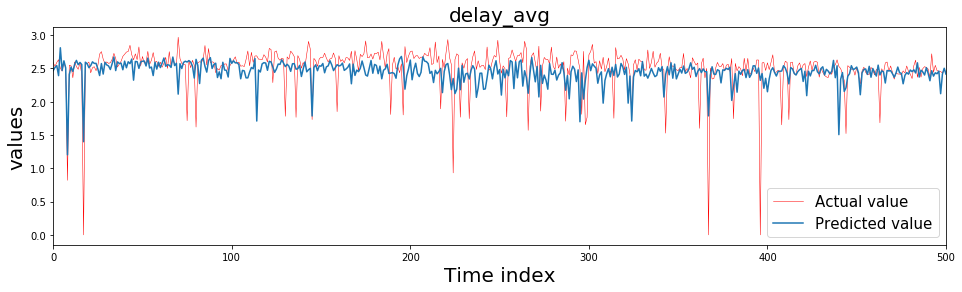

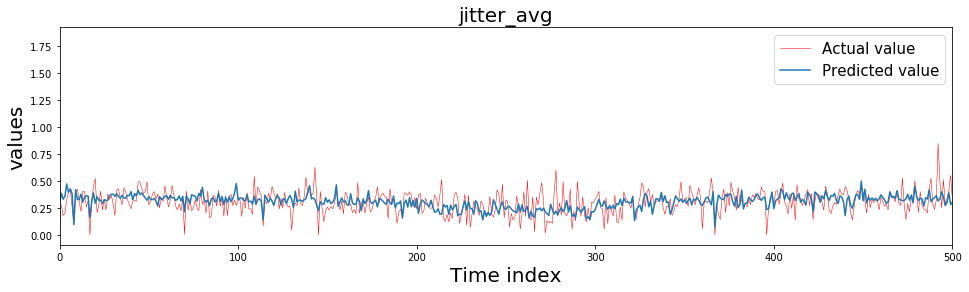

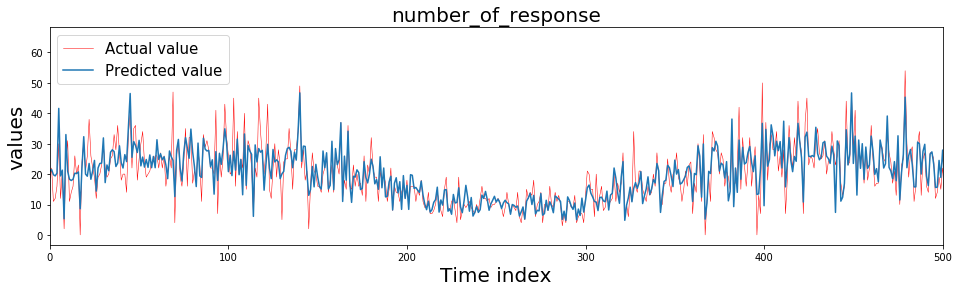

In [651]:
plot_all_samples(y_pred, y_test, 0, 500)

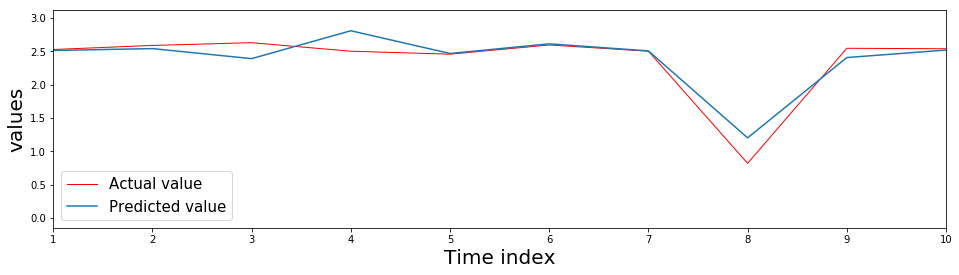

In [645]:
plot_samples(y_pred[:,0], y_test[['delay_avg']],1,10)